In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

First load the data and see what's in it. When we try to plot line chart, we found column is type string. So we want to transform the type to numeric. And some values in Order_Demand are in parentheses, like '(1)', which cannot be transformed. Therefore we delete the parentheses parts.

In [48]:
data_ori = pd.read_csv('data/historical_product_demand.csv', parse_dates=['Date'], infer_datetime_format=True)
data_ori['doy'] = data_ori.Date.apply(lambda t:t.dayofyear)
data_ori.sample(1)

,Product_Code,Warehouse,Product_Category,Date,Order_Demand,doy
406095,Product_0485,Whse_J,Category_013,2013-12-10,40,344.0


In [51]:
data_pro = data_ori.dropna()
#data_pro[112280:112300]
data_pro['Order_Demand'] = pd.to_numeric(data_pro['Order_Demand'].replace( '[\$,)]','', regex=True ).replace( '[(]','',   regex=True ))
data_pro.sample(2)

/home/kaidong/Softwares/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Product_Code,Warehouse,Product_Category,Date,Order_Demand,doy
401558,Product_2039,Whse_J,Category_011,2013-01-31,1,31.0
751367,Product_0065,Whse_J,Category_019,2015-03-23,1000,82.0


At the beginning, I actually made a mistake that I take for granted the data is only for a year. So I group day of year and plot the chart. Then I realize the data covers from 2012 to 2017. So I have to redo all the daa processing first.

In [53]:
cd = data_pro.sample(1)['Product_Code'].values[0]
print cd
df_prod = data_pro[data_pro.Product_Code == cd]
df_prod = df_prod.sort_values(by=['doy'])
#df_prod
print df_prod.Warehouse.unique()
df_prod.sample(1)

Product_0533
['Whse_S' 'Whse_A' 'Whse_J']


,Product_Code,Warehouse,Product_Category,Date,Order_Demand,doy
998388,Product_0533,Whse_S,Category_022,2016-01-10,11,10.0


Warehouse
Whse_A    AxesSubplot(0.125,0.125;0.775x0.755)
Whse_J    AxesSubplot(0.125,0.125;0.775x0.755)
Whse_S    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

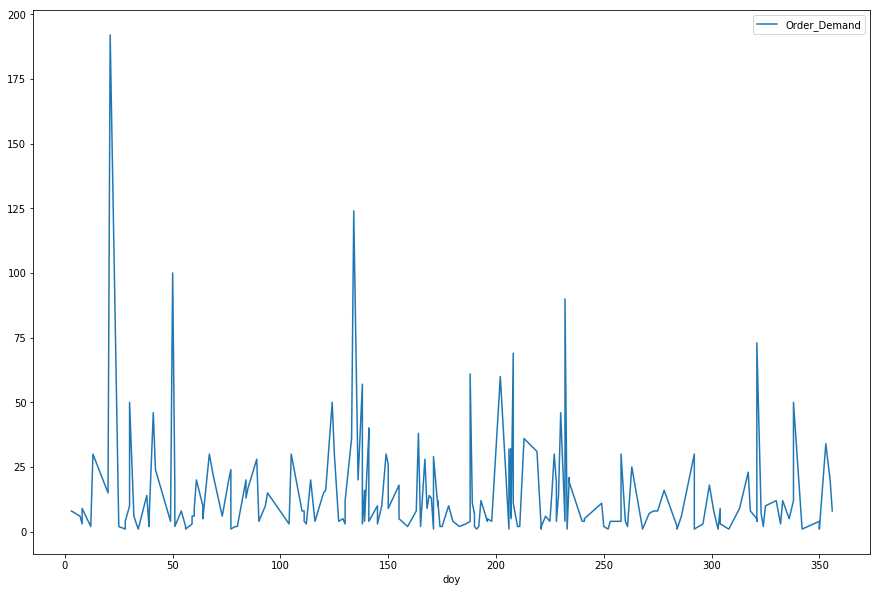

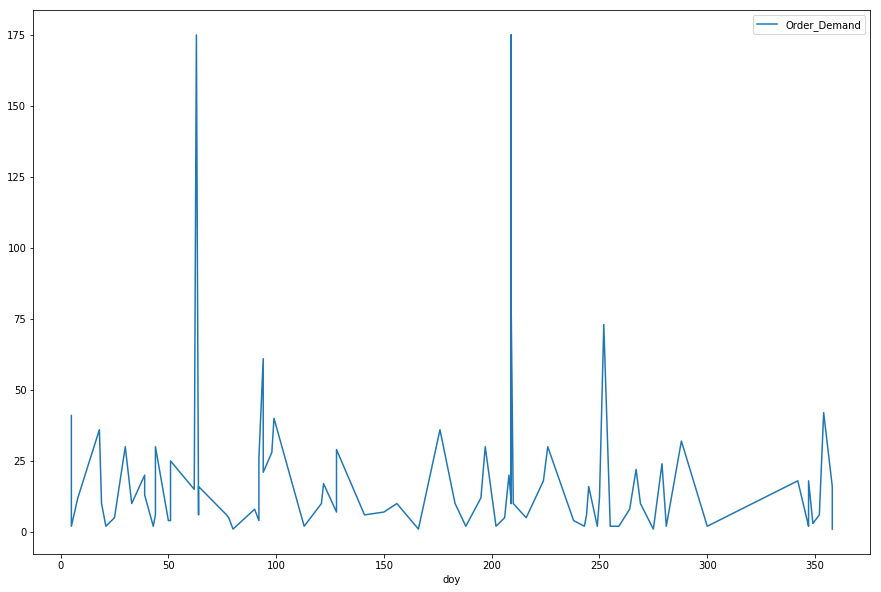

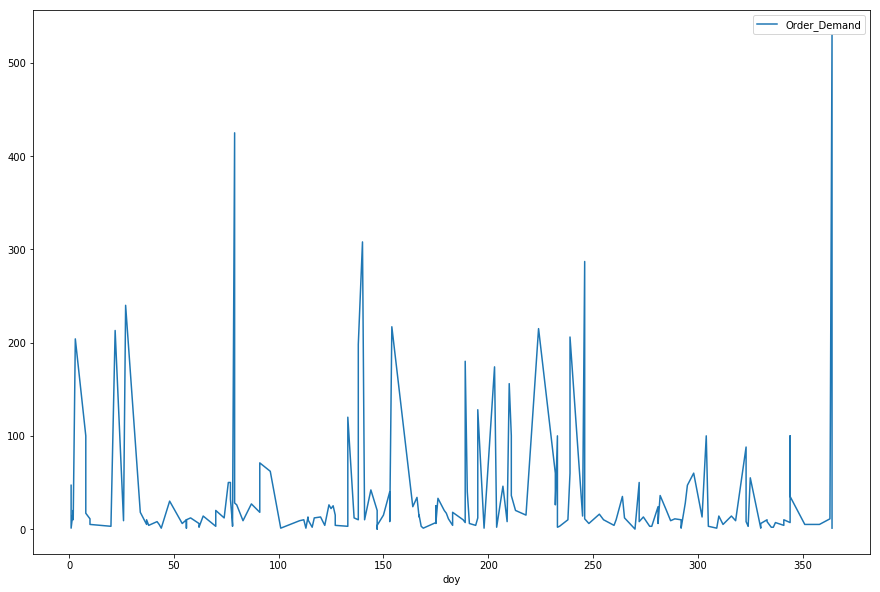

In [55]:
df_prod.groupby('Warehouse').plot(kind='line', x='doy', y='Order_Demand', figsize=(15,10))

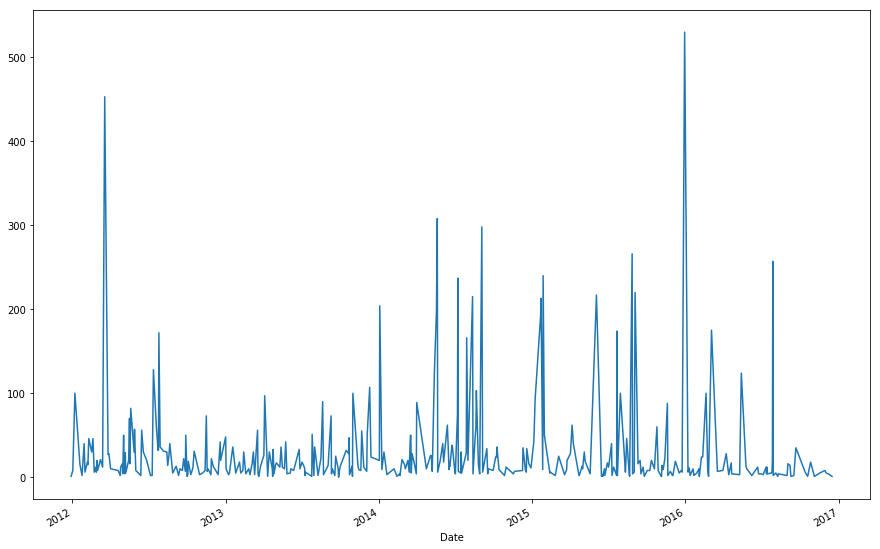

In [65]:
df_days = df_prod.groupby('Date')['Order_Demand'].sum()
df_days
df_days.plot(kind='line', x='Date', figsize=(15,10))

The information about the demand is actually very limited. The only factor that will affect the demand is probably the warehouse. So we will perform forecast for individual warehouse and add them up. And also we will perform the demand for a product from all warehouses. Then two results will be compared

In [71]:
s_days = df_prod.groupby('Date')['Order_Demand'].sum()
df_all_wh = df_days.to_frame()
df_all_wh['DateCol'] = df_all_wh.index
df_all_wh.rename(columns={'DateCol':'ds', 'Order_Demand':'y'}, inplace = True)

df_all_wh.sample(1)

,y,ds
Date,,
2014-09-30,8,2014-09-30


So first, we forecast for the overall product demand from all warehouses

In [75]:
from fbprophet import Prophet

In [94]:
m = Prophet()
m.fit(df_all_wh)

future_demand = m.make_future_dataframe(periods = 180)

fcst_all = m.predict(future_demand)
fcst_all = fcst_all[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
fcst_all.tail()

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
552,2017-06-09,17.708948,-54.383035,90.651765
553,2017-06-10,3.451162,-63.619054,80.660318
554,2017-06-11,25.315844,-44.644080,95.548974
555,2017-06-12,13.349005,-56.944174,84.355934
556,2017-06-13,12.650912,-55.442686,82.276928


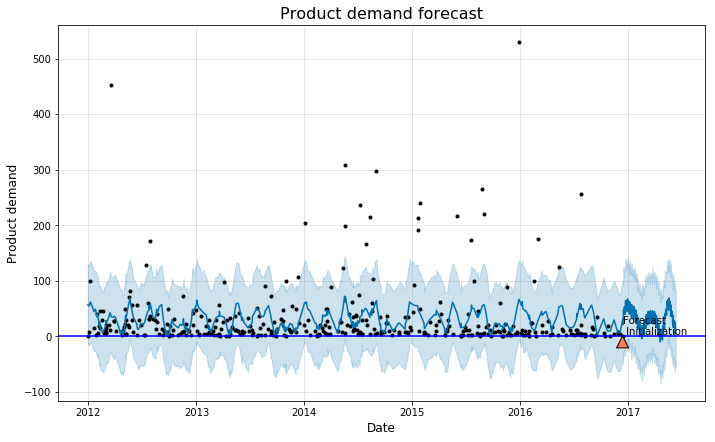

In [99]:
import matplotlib.dates as mdates
import datetime as dt

# Dates
starting_date = dt.datetime(2016, 12, 15)
starting_date1 = mdates.date2num(starting_date)
#trend_date = dt.datetime(2018, 6, 7)
#rend_date1 = mdates.date2num(trend_date)

#pointing_arrow = dt.datetime(2018, 2, 18)
#pointing_arrow1 = mdates.date2num(pointing_arrow)

# Learn more Prophet tomorrow and plot the forecast for amazon.
fig = m.plot(fcst_all)
ax1 = fig.add_subplot(111)
ax1.set_title("Product demand forecast", fontsize=16)
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Product demand", fontsize=12)

# Forecast initialization arrow
ax1.annotate('Forecast \n Initialization', xy=(starting_date1, 1), xytext=(starting_date1,2),
            arrowprops=dict(facecolor='#ff7f50', shrink=0.1),
            )

# Trend emphasis arrow
#ax1.annotate('Upward Trend', xy=(trend_date1, 1225), xytext=(trend_date1,950),
#            arrowprops=dict(facecolor='#6cff6c', shrink=0.1),
#            )

ax1.axhline(y=1, color='b', linestyle='-')

plt.show()

In [93]:
df_all_wh.tail()

,y,ds
Date,,
2016-11-16,5,2016-11-16
2016-11-28,8,2016-11-28
2016-12-01,5,2016-12-01
2016-12-06,4,2016-12-06
2016-12-15,1,2016-12-15
